# Business Analysis project for Yandex.Afisha
## introduction:
**Yandex** — big search engine.<br>
**Afisha** — a russian website about movies and television programs.<br>
**Yandex.Afisha** — the two teamed up in 2014 to present Russians with the option to search showtimes and pre-purchase tickets online. from home or on android and ios supported phones.
## Project Goal — help optimize marketing expenses.

### Questions to answer
#### Product
- How many people use Yandex.Afisha every day, week, and month?
- How many sessions are there per day? (One user might have more than one session.)
- What is the length of each session?
- How often do users come back?

#### Sales
- When do people start buying ( or how long does it take to convert a user to a customer)?
- How many orders do they make during a given period of time?
- What is the average purchase size?
- How much money do they bring? (LTV)

#### Marketing
- How much money was spent? Overall/per source/over time
- How much did customer acquisition from each of the sources cost?
- How worthwhile where the investments? (ROI)
- Plot graphs to display how these metrics differ for various devices and ad sources and how they change in time.

#### conclusions to make:
- advise marketing experts how much money to invest and where.
- What sources/platforms would you recommend?

## Looking at the data:

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
#reading data files
## date columns are in default date format and loaded as date dtype
##device column in visits is a categorical column type and loaded as such

visits_col_names = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

visits = pd.read_csv('visits_log_us.csv', dtype = {'Device' : 'category'}, parse_dates=['Start Ts', 'End Ts'])
orders = pd.read_csv('orders_log_us.csv', parse_dates = ['Buy Ts'])
costs =  pd.read_csv('costs_us.csv', parse_dates = ['dt'])

## The Data Contains 3 files
### File 1: `Visits`
The visits table (server logs with data on website visits):
- `Uid` — user's unique identifier
- `Device` — user's device
- `Start Ts` — session start date and time
- `End Ts` — session end date and time
- `Source Id` — identifier of the ad source the user came from

#### Regular checkups

In [3]:
display(visits.sample(5))

,Device,End Ts,Source Id,Start Ts,Uid
210003,touch,2017-09-23 20:14:00,3,2017-09-23 20:14:00,13191064625879610176
74984,desktop,2018-02-13 08:32:00,2,2018-02-13 08:28:00,216684620857885175
211124,desktop,2018-04-29 10:55:00,2,2018-04-29 10:25:00,348238000252671115
207717,desktop,2017-08-08 21:00:00,2,2017-08-08 20:54:00,16226762941796544177
163834,desktop,2017-10-22 22:21:00,5,2017-10-22 22:20:00,16694538505069466494


In [4]:
display(visits.info(memory_usage = "deep"))
print('-------------------------\nTotal memory usage before optimizing:', ((pd.read_csv('visits_log_us.csv').memory_usage(deep = True).sum()) / 1024 / 1024).round(2))
print('Total memory usage before optimizing:', ((visits.memory_usage(deep = True).sum()) / 1024 / 1024).round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


None

-------------------------
Total memory usage before optimizing: 79.33
Total memory usage before optimizing: 11.31


In [5]:
visits[['End Ts', 'Start Ts']].describe(datetime_is_numeric = True)

,End Ts,Start Ts
count,359400,359400
mean,2017-12-18 06:28:15.036205056,2017-12-18 06:17:32.010517760
min,2017-06-01 00:02:00,2017-06-01 00:01:00
25%,2017-10-15 09:45:45,2017-10-15 09:41:00
50%,2017-12-18 18:59:30,2017-12-18 18:46:00
75%,2018-02-28 10:08:15,2018-02-28 09:54:00
max,2018-06-01 01:26:00,2018-05-31 23:59:00


#### No missing data or dupliacates

In [6]:
print('Missing data:')
display(visits.isnull().sum())

print('-----------')
print('Duplicaes:')
display(visits.duplicated().sum())

Missing data:


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

-----------
Duplicaes:


0

In [7]:
visits['Source Id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

In [8]:
visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [9]:
visits.min()

<ipython-input-9-a46d2e463f7e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  visits.min()


End Ts       2017-06-01 00:02:00
Source Id                      1
Start Ts     2017-06-01 00:01:00
Uid               11863502262781
dtype: object

#### Visits has two sessions that ended before they even started, by two different users:
this must be some sort of bug that needs to be checked.

In [10]:
visits[(visits['End Ts'] < visits['Start Ts'])]

,Device,End Ts,Source Id,Start Ts,Uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


##### Finding more about the users with bugged TimeStamp

In [11]:
#letstake a closer look:
visits[(visits["Uid"] == 4621202742905035453) | (visits["Uid"] == 13092152539246794986)].sort_values(['Uid', 'Start Ts']).sort_values(['Uid', 'Start Ts'])

,Device,End Ts,Source Id,Start Ts,Uid
297496,desktop,2018-03-19 19:09:00,9,2018-03-19 18:40:00,4621202742905035453
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453
163633,desktop,2018-03-25 12:56:00,9,2018-03-25 12:52:00,4621202742905035453
124454,desktop,2018-03-27 14:07:00,9,2018-03-27 13:47:00,4621202742905035453
15861,desktop,2018-05-22 21:31:00,3,2018-05-22 20:55:00,4621202742905035453
230629,desktop,2017-11-12 16:53:00,1,2017-11-12 16:49:00,13092152539246794986
297902,desktop,2017-11-17 01:17:00,3,2017-11-17 00:34:00,13092152539246794986
96975,desktop,2017-11-21 02:00:00,1,2017-11-21 01:24:00,13092152539246794986
100434,desktop,2017-11-27 14:44:00,1,2017-11-27 14:38:00,13092152539246794986
285336,desktop,2017-11-28 18:36:00,1,2017-11-28 18:28:00,13092152539246794986


##### Ok, but did they purchase anything?
Checking same uid on orders table shows no results meaning these Uid's are not in it

In [12]:
orders[(orders['Uid'] == 4621202742905035453) | (orders['Uid'] == 13092152539246794986)]

,Buy Ts,Revenue,Uid


##### These two users did not purchase anything
When checking the orders table, we can see that these users have not purchased anything, so many sessions and no purchase?<br>
##### Recommendation
- Investigate about the time bug
- Investigate why did users had so many entries and no purchase
    - is the price not fair?
    - is there a difficulty placing a purchase? 
    - does this issue have any connection to the session timing bug?

#### Finding the share of :
1. Devices used
2. Visit source

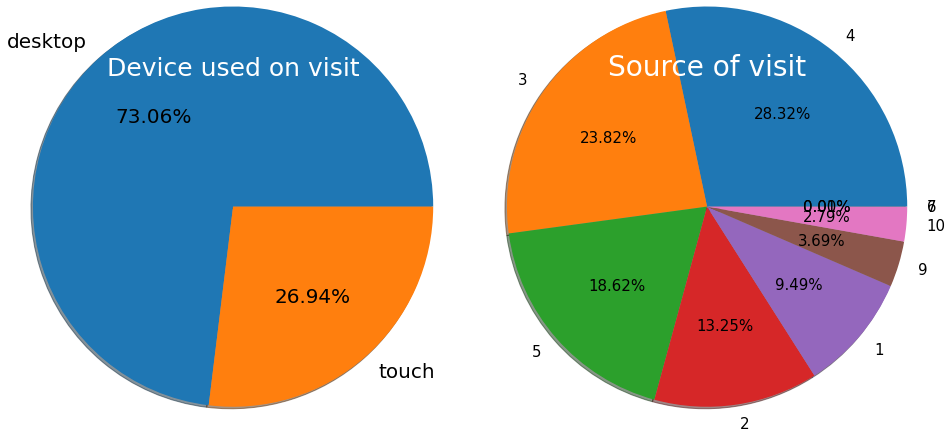

In [13]:
plt.figure(figsize = (14,8))
plt.subplot(1, 2, 1)
visits['Device'].value_counts().plot.pie(autopct="%.2f%%",shadow = True, radius = 2, textprops={'fontsize': 20}, label = '')
plt.title('Device used on visit', size = 25, color = 'white')
plt.subplot(1, 2, 2)
visits['Source Id'].value_counts().plot.pie(autopct="%.2f%%",shadow = True, radius = 2, textprops={'fontsize': 15}, label = '')
plt.title('Source of visit', size = 28, color = 'white')
plt.tight_layout()
plt.show()

##### Summary and Conclusions
- There are no missing values, no duplicates, or zeros. date ranges seem to be well structured.
- Column names contain spaces and high case letters. needs to be fixed.
- 73% of the purchases are done from desktop, it is used much more to buy tickets than phones (or touch devices).
- The 2 most common ad sources are sources 4, and 3. with 28% and 23% of the total sources. 6, 7, 10, and 9 are hardly ever used at all. perhaps it's a good idea to check what's up with them. especially 6 and 7.
- Two rows have some sort of an error in their session logging time, as the end ts is earlier than the start ts. it's probably a system error that needs to be checked.<br>
    Checking into these users we found that they did enter the service a good amount of times and not once did they purchase anything. is this because they tried and could not complete it? or the tickets are just too pricey?  we need to examine this.

### File 2: `Orders`
The orders table (data on orders):
- `Uid` — unique identifier of the user making an order
- `Buy Ts` — order date and time
- `Revenue` — Yandex.Afisha's revenue from the order


#### Regular checkups

In [14]:
orders.sample(5)

,Buy Ts,Revenue,Uid
30439,2018-01-22 11:50:00,0.98,5698637542347568101
16187,2017-11-05 10:49:00,7.33,1305021695722051578
16527,2017-11-07 19:27:00,3.05,16292937320753657419
24747,2017-12-18 16:11:00,4.58,6537801636127672245
8620,2017-09-22 12:18:00,1.17,4580707622638622296


In [15]:
orders.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [16]:
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


#### No missing data or duplicates

In [17]:
print('Missing data:')
display(orders.isnull().sum())

print('-----------')
print('Duplicaes:')
display(orders.duplicated().sum())

Missing data:


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

-----------
Duplicaes:


0

#### Revenue Distribution

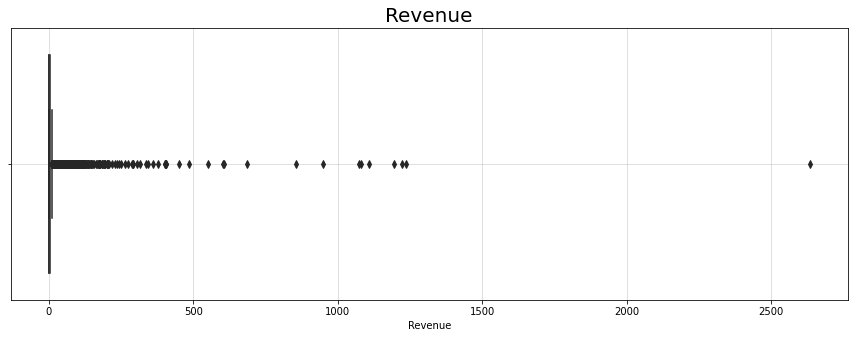

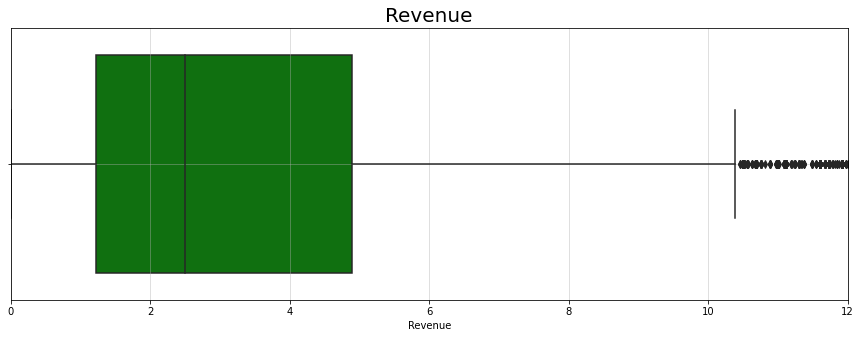

Revenue above 15: 8.23%
0 revenue: 0.10%


In [18]:
#boxplotting revenue column:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x = orders['Revenue'], color = 'green')
plt.title('Revenue', size = 20)
plt.grid(alpha = 0.5)

#zooming in
fig = plt.figure(figsize=(15,5))
sns.boxplot(x = orders['Revenue'], color = 'green')
plt.xlim(0, 12)
plt.title('Revenue', size = 20)
plt.grid(alpha = 0.5)
plt.show()


#calculating outlier and 0 revenue values:
print('Revenue above 15: {:.2%}'.format(len(orders[orders['Revenue'] > 10])/len(orders['Revenue'])))
print('0 revenue: {:.2%}'.format(len(orders[orders['Revenue'] == 0])/len(orders['Revenue'])))

##### There are some big outliers in revenue.
These are but most likely big customers, like companies who buy many tickets.

In [19]:
#a look at the high revenue values:  it's interesting to see the same Uid is in the majority of top buyers
orders.sort_values('Revenue', ascending = False).head(10)

,Buy Ts,Revenue,Uid
23244,2017-12-10 20:17:00,2633.28,5539673724080479777
36522,2018-02-23 08:54:00,1236.28,11149926373378902217
36682,2018-02-24 09:25:00,1221.37,11149926373378902217
23165,2017-12-10 13:04:00,1195.64,5539673724080479777
24607,2017-12-17 18:06:00,1109.10,11149926373378902217
47507,2018-05-16 19:53:00,1080.44,11149926373378902217
40386,2018-03-18 09:13:00,1073.11,11149926373378902217
45653,2018-04-26 20:06:00,948.44,11149926373378902217
40020,2018-03-15 19:22:00,856.78,11149926373378902217
40643,2018-03-19 18:15:00,685.67,11149926373378902217


In [20]:
#in fact we found another top customer...  may be worth checking who they are and give them a hug?
orders.sort_values('Revenue', ascending = False).head(30)['Uid'].value_counts()

11149926373378902217    12
5539673724080479777     11
16152080406371512880     1
255246909617571582       1
12069004609949546307     1
17999372575896145244     1
17296569523374666680     1
8539015707073391293      1
17956827303229825606     1
Name: Uid, dtype: int64

In [21]:
#looking at 0 revenues, grouping by user:
orders[orders['Revenue'] == 0].groupby('Uid')[['Revenue']].count().reset_index()

,Uid,Revenue
0,184148767273119549,1
1,1149062814762747892,1
2,1879819502567241225,1
3,2037345392173160982,12
4,2636645662067512510,1
5,2883839899480223178,2
6,2936104404423239931,1
7,4927261749585088199,4
8,5342067285161169772,1
9,5570343171257035973,4


#### Revenue is very interesting
- Some 0's in revenue, Possible causes: 
    - Data error or bug in the purchase
    - Free tickets, maybe through a refund, maybe some users can get free tickets (like company employees), maybe prepaid ticket?.
- A couple of user id's have more than 1 purchase with 0 revenue.
- Very high revenue outliers.
    - The revenue median is 2.5, and the maximum value for revenue gets as high as 2633!!.
    - If we check the highest revenues for each Uid we can find two Uid's with 11 and 12 purchases.
        - These can be something like be companies that buy tickets to all their employees. it might be some error too.

### File 3: `Costs`
The costs table (data on marketing expenses):
- `source_id` — ad source identifier
- `dt` — date
- `costs` — expenses on this ad source on this day

#### Regular checkups

In [22]:
costs.sample(5)

,source_id,dt,costs
1152,4,2017-08-03,167.72
325,1,2018-04-24,35.06
620,2,2018-02-13,145.64
2437,10,2018-02-14,39.02
1074,3,2018-05-17,156.52


In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [24]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


#### No missing data or duplicates

In [25]:
print('Missing data:')
display(costs.isnull().sum())

print('-----------')
print('Duplicaes:')
display(costs.duplicated().sum())

Missing data:


source_id    0
dt           0
costs        0
dtype: int64

-----------
Duplicaes:


0

#### Highest cost values

In [26]:
costs.sort_values('costs', ascending = False).head(10)

,source_id,dt,costs
902,3,2017-11-24,1788.28
919,3,2017-12-11,1061.18
1005,3,2018-03-07,996.15
853,3,2017-10-06,980.52
936,3,2017-12-28,858.28
975,3,2018-02-05,845.75
942,3,2018-01-03,844.63
905,3,2017-11-27,831.73
874,3,2017-10-27,824.66
979,3,2018-02-09,822.49


#### Every source id has 363 rows , except source 5  that has 364

In [27]:
costs['source_id'].value_counts()

5     364
1     363
2     363
3     363
4     363
9     363
10    363
Name: source_id, dtype: int64

#### When checking the difference between `dt` slices of source 5 and other sources 2018-03-31 pops up

In [28]:
#showing difference between isn't in other source slices
np.setdiff1d(costs[costs['source_id'] == 5]['dt'].unique(), costs[costs['source_id'] == 1]['dt'].unique())
np.setdiff1d(costs[costs['source_id'] == 5]['dt'].unique(), costs[costs['source_id'] == 2]['dt'].unique())
np.setdiff1d(costs[costs['source_id'] == 5]['dt'].unique(), costs[costs['source_id'] == 3]['dt'].unique())

array(['2018-03-31T00:00:00.000000000'], dtype='datetime64[ns]')

##### It was saturday
Showing all data from the date `2018-03-31`

In [29]:
display(costs[costs['dt']== '2018-03-31'])
#it was saturday:
print(pd.DatetimeIndex(costs[costs['dt']== '2018-03-31']['dt']).day_name())

,source_id,dt,costs
1755,5,2018-03-31,0.7


Index(['Saturday'], dtype='object', name='dt')


#### Total Ad Costs Per Source

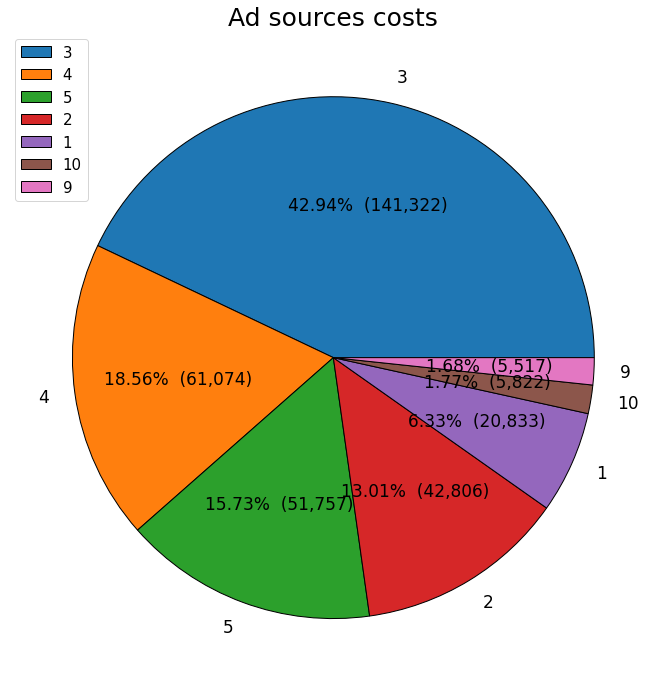

In [30]:
costpersrcid = costs.groupby('source_id')['costs'].sum().sort_values(ascending = False).reset_index()
plt.figure(figsize = (12,12))
plt.pie(costpersrcid['costs'], labels = costpersrcid['source_id'], wedgeprops={"edgecolor" : "k", 'linewidth' : 1},
               textprops={'color' : 'k', 'fontsize': 17},
        autopct = lambda x : '{:.2f}%  ({:,.0f})'.format(x,x * sum(costpersrcid['costs'])/100))
plt.title('Ad sources costs', size = 25)
plt.legend(fontsize = 15)
plt.show()

#### Costs table conclusions
- Column names in this one have no spaces or high-case letters.
- No missing values or duplicated rows.
- as the dt column shows every day in the date range, there is a value only in "ad source 5" at the 2018-03-31.
    a quick search shows this day was saturday and the first day of the Passover holiday (Песах). are the other ad sources jewish and were on hoilday?. is this a bug? perhaps there is another reason. it is worth a check.
- the ad source that costs the most is "source 5. 43% of the expenses are on this source, 10 and 9 are the smallest with about 1.7% each.     

### Conclusions after checking the data:
- The data has logs for Yandex.Afisha from June 2017 through May 2018, with 3 dataframes:
    - **visits**: Server logs with data on website visits.
    - **orders**: Data on the orders made.
    - **source**: Data on marketing expenses.
- There were no missing values and duplicates. the data seems to be well structured.
- In the revenue column in orders df there were 0 values, could be free tickets aquired. Either way, a purchase is a purchase, it is probably there for a reason, and for the analysis we will conisder them as valid purchases.
- There were also VERY high outliers, which could be purchases made for a large group (such as a company).
- There seems to be expense data for each ad source, on every day throughout the year. Except the 2018-03-31, this date only contains data for the "5" ad source, if it's an event that happened that day or a problem, it needs to be examined.
- **Other facts:**
    - 73% of the service purchases were made from desktop.
    - The 2 most common ad sources that users came through are "3" and "4", with 28% and 23% percent, "6", "7", "10, and "9" brought very few.
    - The ad source service that has cost the most to the company is source "3" with 43% of the sum costs of all sources, "10", and "9" has the smallest cost with about 1.7% each. They also bring few user purchases. "6" and "7" who also brought very very few purchases are not in the costs data. perhaps they are free of charge?
    - What happened to ad source "8"?  it's not in the data.
    - We found two users with whose end ts in visits was earlier than their start ts in two different rows, need to report the bug. 
        - But we also found that the same users entered the service a handful of times and did not purchase anything, maybe it's worth checking that too.<br>
        - The two rows contain data values in other field and will be ambraced with love in spite of their deformation, as they are a fraction of the data and should not cause any trouble especially if we know about them.
- **Required in preprocess:** Change column names to have no spaces, and also use lower-case letters in the names.


## A bit of preprocessing
### Renaming the column names to get rid of high case letters and replace spaces with '_'

In [31]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

## Getting some answers:
### Product:
#### How many people use it every day, week, and month?

##### Daily

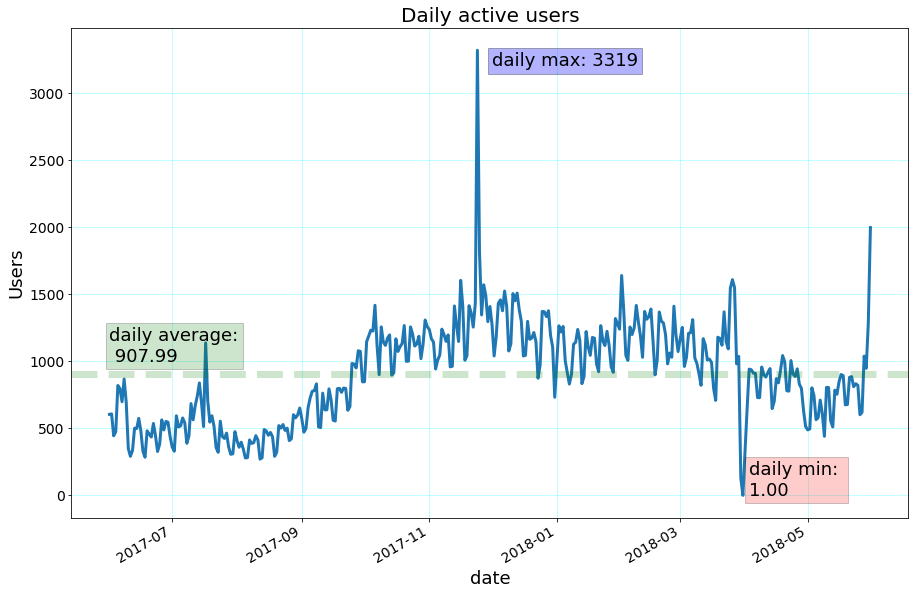

In [32]:
#first adding day, week(starting monday), and month:
visits['day']   = visits['start_ts'].astype('datetime64[D]')
visits['week']  = (visits['start_ts'].dt.date.astype('datetime64') - pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='d'))
visits['month'] = visits['start_ts'].astype('datetime64[M]')


#groupby
daily = visits.groupby('day').agg({'uid':'nunique'}).reset_index()

#plot
daily.plot(x="day", y="uid", kind="line", figsize = (15,10), legend = False, linewidth = 3)
plt.title('Daily active users', size = 20)
plt.grid(color = 'cyan', alpha = 0.3)
plt.axhline(y = (daily['uid'].mean()), color = 'g', linewidth = 7, alpha = 0.2, ls = '--')
plt.ylabel('Users', size = 18)
plt.xlabel('date', size = 18)
plt.text('2017-6-1', 1000, "daily average:\n {:.2f}".format(daily['uid'].mean()), bbox = dict(facecolor = 'g', alpha = 0.2), size = 18)
plt.text('2017-12-1', 3200, "daily max: {}".format(daily['uid'].max()), bbox = dict(facecolor = 'b', alpha = 0.3), size = 18)
plt.text('2018-4-3', 0, "daily min: \n{:.2f}".format(daily['uid'].min()), bbox = dict(facecolor = 'r', alpha = 0.2), size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

##### Daily active users:
- The average DAU is 908.
- We see that from october to april there are more users that the rest of the year. maybe because these are the colder months of the year where indoor activities and entertainment is preferable?
- There is a huge spike in november 24 of 3319 users that day, it could be a good marketing move, or some huge show, or maybe even a data error.
- In march 31, there was only 1 user active, this looks like a bug of some kind, worth a check. it could also be a very unlucky day.

##### Weekly

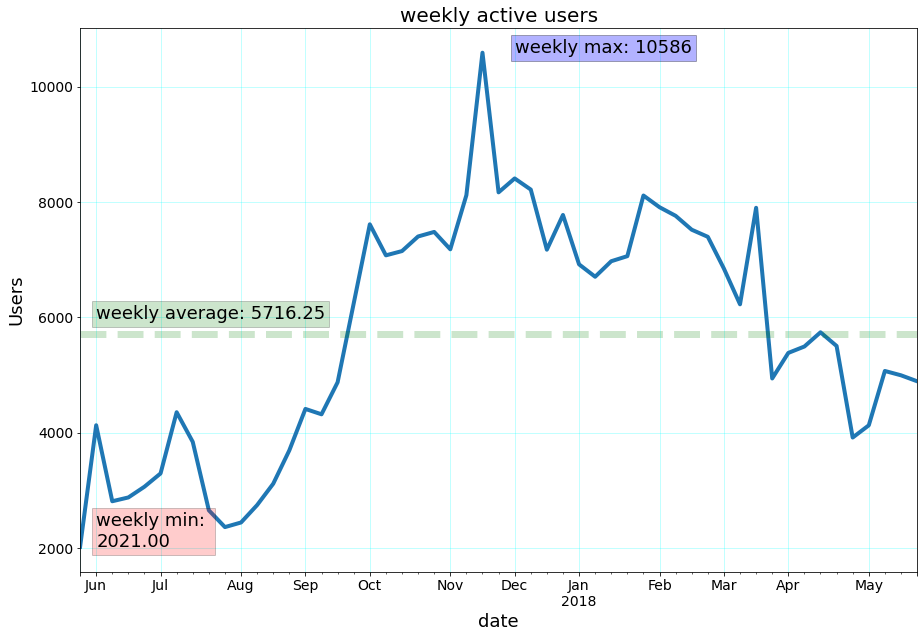

In [33]:
weekly = visits.groupby('week').agg({'uid':'nunique'}).reset_index()

weekly.plot(x="week", y="uid", kind="line", figsize = (15,10), legend = False, linewidth = 4)
plt.title('weekly active users', size = 20)
plt.grid(color = 'cyan', alpha = 0.3)
plt.axhline(y = (weekly['uid'].mean()), color = 'g', linewidth = 7, alpha = 0.2, ls = '--')
plt.ylabel('Users', size = 18)
plt.xlabel('date', size = 18)
plt.text('2017-6-1', weekly['uid'].mean()+250, "weekly average: {:.2f}".format(weekly['uid'].mean()), bbox = dict(facecolor = 'g', alpha = 0.2), size = 18)
plt.text('2017-12-1', weekly['uid'].max(), "weekly max: {}".format(weekly['uid'].max()), bbox = dict(facecolor = 'b', alpha = 0.3), size = 18)
plt.text('2017-6-1', weekly['uid'].min(), "weekly min: \n{:.2f}".format(weekly['uid'].min()), bbox = dict(facecolor = 'r', alpha = 0.2), size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

##### Weekly active users:
- WAU average is 5716.
- Just like in the DAU graph, october to april are the good months with above average users active.
- The maximun amount of WAU was 10586 thanks to this crazy one day spike in november 24.
- And the minimum amount in in the last week of july and first week of august with 200-2300 WAU. We will ignore may since it's the the data begins at june.

##### Monthly

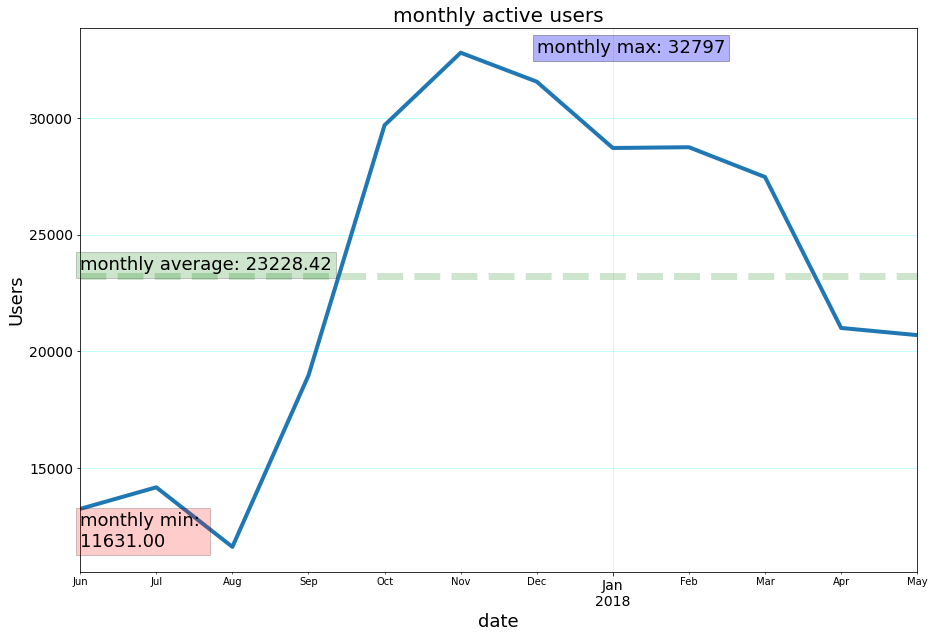

In [34]:
monthly = visits.groupby('month').agg({'uid':'nunique'}).reset_index()

monthly.plot(x="month", y="uid", kind="line", figsize = (15,10), legend = False, linewidth = 4)
plt.title('monthly active users', size = 20)
plt.grid(color = 'cyan', alpha = 0.3)
plt.axhline(y = (monthly['uid'].mean()), color = 'g', linewidth = 7, alpha = 0.2, ls = '--')
plt.ylabel('Users', size = 18)
plt.xlabel('date', size = 18)
plt.text('2017-6-1', monthly['uid'].mean()+250, "monthly average: {:.2f}".format(monthly['uid'].mean()), bbox = dict(facecolor = 'g', alpha = 0.2), size = 18)
plt.text('2017-12-1', monthly['uid'].max(), "monthly max: {}".format(monthly['uid'].max()), bbox = dict(facecolor = 'b', alpha = 0.3), size = 18)
plt.text('2017-6-1', monthly['uid'].min(), "monthly min: \n{:.2f}".format(monthly['uid'].min()), bbox = dict(facecolor = 'r', alpha = 0.2), size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

##### Monthly active users:
- The MAU average is 23,228.
- The graph is the same as it's previous, just on a larger, smoother scale.
- Max MAU is 32,797 at in november.
- Min MAU is 11,631 in august.
- We can see everything we saw in the smaller scale graphs of WAU and DAU.

#### How many sessions are there per day?

In [35]:
daily_s = (visits.groupby('day').agg({'start_ts': 'count', 'uid': 'nunique'}).rename(columns={'start_ts': 'sessions', 'uid': 'users'})).reset_index()
daily_s.head()
daily_s['spu'] = daily_s['sessions'] / daily_s['users']
daily_s.sort_values('spu', ascending = False).head()

,day,sessions,users,spu
176,2017-11-24,4042,3319,1.217837
180,2017-11-28,1746,1493,1.169457
177,2017-11-25,2089,1817,1.149697
245,2018-02-01,1878,1640,1.145122
181,2017-11-29,1480,1296,1.141975


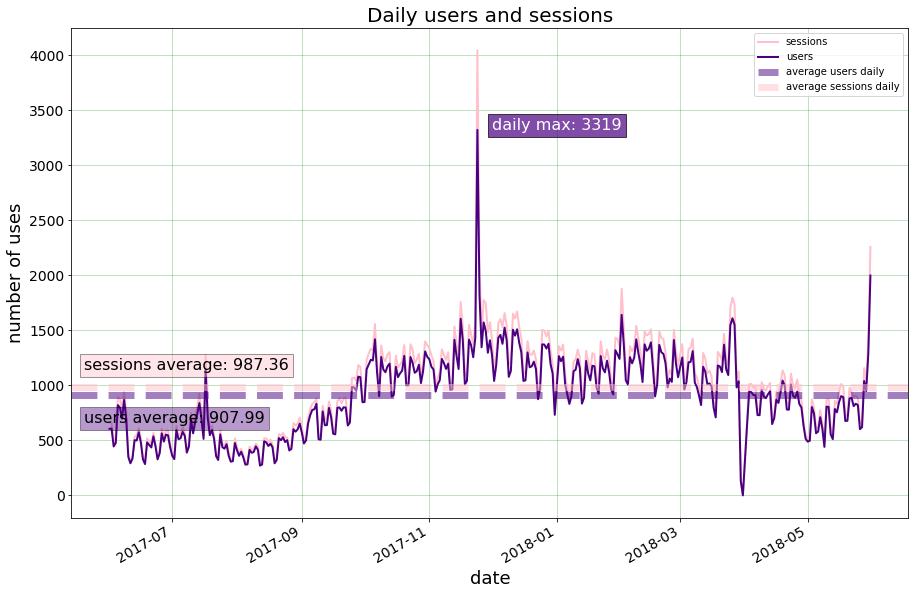

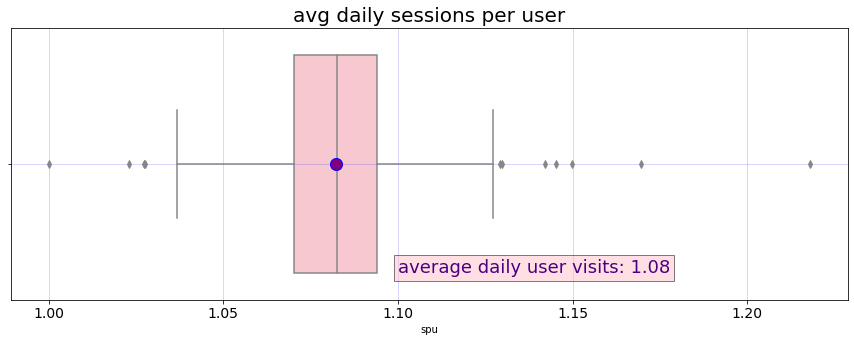

In [36]:
daily_s.plot(kind = 'line', x = 'day', y = ['sessions', 'users'], color = ['pink','indigo'],figsize = (15,10), linewidth = 2)
plt.grid(alpha = 0.3, color = 'g')
plt.title('Daily users and sessions', size = 20)
plt.axhline(y = (daily_s['users'].mean()), color = 'indigo', linewidth = 7, alpha = 0.5, ls = '--', label = 'average users daily')
plt.axhline(y = (daily_s['sessions'].mean()), color = 'pink', linewidth = 7, alpha = 0.5, ls = '--', label = 'average sessions daily')
plt.ylabel('number of uses', size = 18)
plt.legend()
plt.xlabel('date', size = 18)
plt.text('2017-5-20', daily_s['users'].mean()-250, "users average: {:.2f}".format(daily_s['users'].mean()), bbox = dict(facecolor = 'indigo', alpha = 0.4), size = 16)
plt.text('2017-5-20', daily_s['sessions'].mean()+150, "sessions average: {:.2f}".format(daily_s['sessions'].mean()), bbox = dict(facecolor = 'pink', alpha = 0.4), size = 16)
plt.text('2017-12-1', daily_s['users'].max(), "daily max: {}".format(daily_s['users'].max()), color ='white', bbox = dict(facecolor = 'indigo', alpha = 0.7), size = 16)
#plt.text('2018-1-1', daily_s['users'].min(), "daily min: {:.2f}".format(daily_s['users'].min()), bbox = dict(facecolor = 'pink', alpha = 0.5), size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

fig = plt.figure(figsize=(15,5))
sns.boxplot(x = daily_s['spu'], showmeans=True, meanprops= {"marker":"o", "markeredgecolor":"b", "markerfacecolor":"purple", "markersize":"12"}, color = 'pink')
plt.title('avg daily sessions per user', size = 20)
plt.grid(alpha = 0.2, color = 'b')
plt.text(1.1, 0.4, "average daily user visits: {:.2f}".format(daily_s['spu'].mean()), color ='indigo', bbox = dict(facecolor = 'pink', alpha = 0.5), size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

##### In average, only a fraction of the users use the product a second time at the same day.
- The daily usage per user and the the daily sessions per user are very similar.
- The average unique user sessions per day is 1.08.
- The average daily sessions number is 987.
- The average daily uses per user is 908.

#### What is the length of each session?

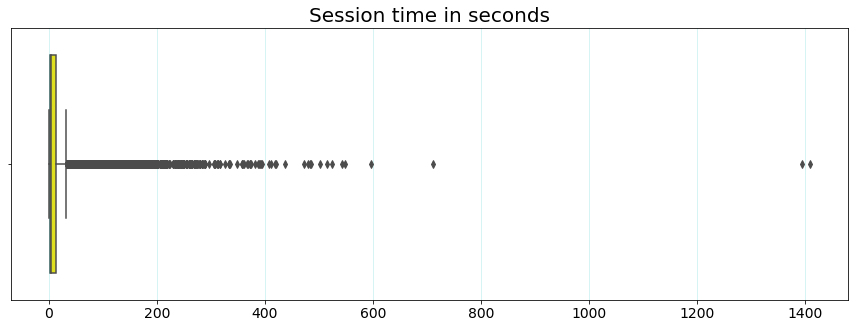

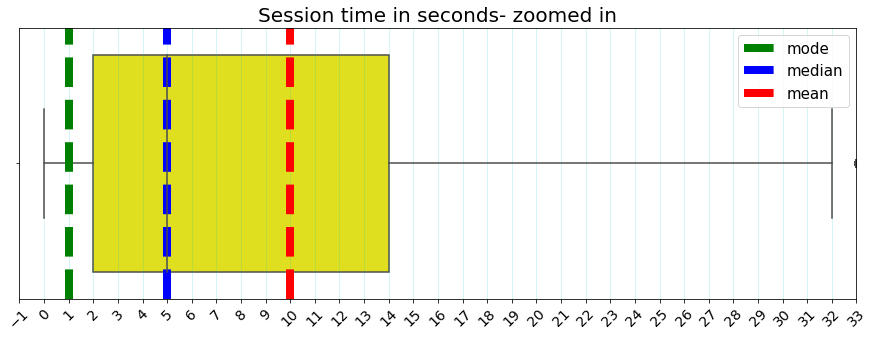

 The most frequent session length is 60 seconds.
 The average session length is 643 seconds.
 The median of session length is 300 seconds.


In [37]:
#creating session times:
sessiontime = (visits['end_ts'] - visits['start_ts']).dt.seconds

#boxplotting session times:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x = sessiontime / 60, color = 'yellow')
plt.grid(axis = 'x',alpha = 0.2, color = 'c')
plt.title('Session time in seconds', size = 20)
plt.tick_params(axis='both', which='major', labelsize=14)

#zooming in
fig = plt.figure(figsize=(15,5))
sns.boxplot(x = sessiontime / 60, color = 'yellow')
plt.xlim(-1, 33)
plt.title('Session time in seconds- zoomed in', size = 20)
plt.grid(axis = 'x',alpha = 0.2, color = 'c')
plt.axvline(int(sessiontime.mode()/60), ls='--', label = 'mode', color = 'g', linewidth = 8)
plt.axvline(int(sessiontime.median()/60), ls='--', label = 'median', color = 'b', linewidth = 8)
plt.axvline(int(sessiontime.mean()/60), ls='--', label = 'mean', color = 'r', linewidth = 8)
plt.legend(fontsize = 15)
plt.locator_params(axis="x", nbins=34)
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 45)
plt.show()

#print mode, median, and mean values
print('\033[1m The most frequent session length is {} seconds.\n The average session length is {} seconds.\n The median of session length is {} seconds.'.format(int(sessiontime.mode()), int(sessiontime.mean()),int(sessiontime.median())))


##### the most common session time is a minute.
- The data time stamps seem to be rounded by the minute, keeping this in mind, it seems that a minute (60 seconds) is enough for users to complete a session.
- The average time for a session is 10 minutes and 43 seconds, and the median is 5 minutes. 
    - Although most sessions last 60 seconds (a minute), some sessions last much longer (up to 10 to 13 minutes - ignoring the two of 23 hours, these must be incorrect).


- The quick sessions of about 60 seconds are probably done by users who already decided what they want to buy.
- And the longer sessions are probably done by users who wanted to explore their options.
- There could be other factors such as users just leaving their devices idle, or even bugs.

#### How often do users come back?

In [38]:
# creating a column with first visit time for each user:
first_visit = visits.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts': 'first_visit'})
visits = visits.merge(first_visit, how='inner',on='uid')

#creating first visit column showing what month the first visit was:
visits['first_month'] = visits['first_visit'].astype('datetime64[M]')

#creating the monthly lifetime column 
visits['month_lt'] = ((visits['month'] - visits['first_month']) / np.timedelta64(1, 'M')).round().astype('int')

#creating monthly cohorts from first lifetime(0) of users first session month, and calculating retention rate
m_cohorts = (visits.groupby(['first_month', 'month_lt']).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}).reset_index())
first_lifetime = (m_cohorts.query('month_lt == 0')[['first_month', 'users']].rename(columns={'users': 'first_lt'}))
m_cohorts = m_cohorts.merge(first_lifetime, on='first_month')
m_cohorts['retention'] = m_cohorts['users'] / m_cohorts['first_lt']

#creating retention rate for each month, fixing it's index to look pretty, and calculating 
m_retention = m_cohorts.pivot_table(index='first_month', columns='month_lt', values='retention', aggfunc='sum')
m_retention.index = m_retention.index.astype(str)

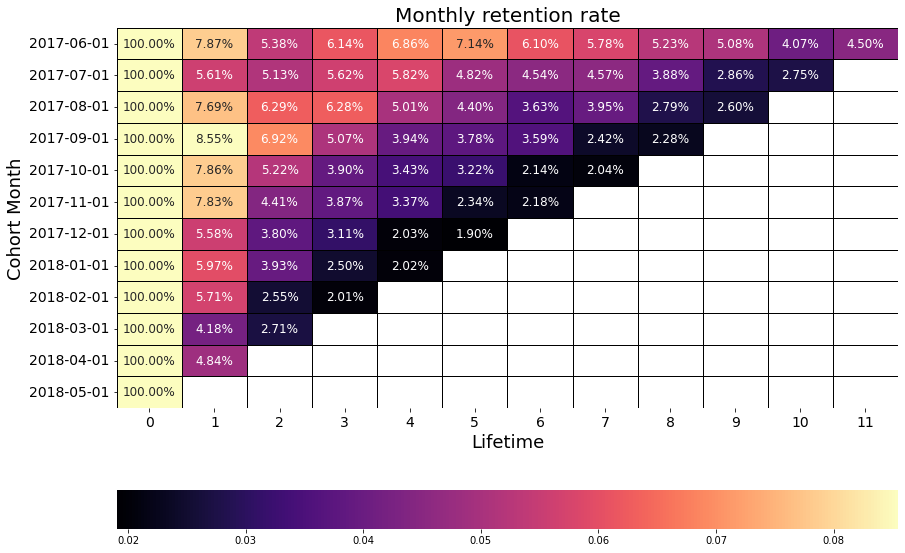

In [39]:
#retention rate heatmap:
plt.figure(figsize = (14,10))
sns.heatmap(m_retention, annot = True, fmt = '.2%', linewidths= 1, linecolor='black',
            cmap = ('magma'), vmin = (m_retention.iloc[:,1:].min().min()), vmax = (m_retention.iloc[:,1:].max().max()),
            annot_kws={'size':12}, cbar_kws={"orientation": "horizontal"})
plt.title('Monthly retention rate', size = 20)
plt.xlabel('Lifetime', size = 18)
plt.ylabel('Cohort Month', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

##### Users do come back, and less often as the months go by:
- We can see that the retention rate is not great, but it is still positive which means a portion of the initial users do come back even after a year.
- November and October 2017 had a small raise in retention rather than a natural drop. perhaps there was a good event or marketing move. It's also the holidays season.
- The decay is strong for the month of april, and on October - November there is a small raise or at least halt in decay. this is parallel to our previous conclusions.

### Sales:
#### When do people start buying?

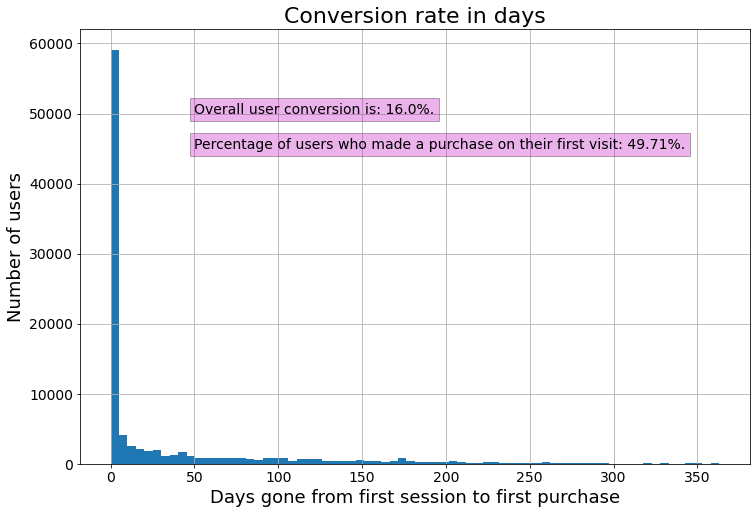

Conversion time median is: 1 days.
Conversion time mean is: 33 days.


In [40]:
#creating a table of grouped user id with first time of purchase, merging the first visit to it and calculating conversion time in days:
first_buy = (orders.groupby('uid')['buy_ts'].min()).reset_index().rename(columns={'buy_ts': 'first_buy'})
first_buy = first_buy.merge(visits[['first_visit','uid']], on = 'uid', how = 'left')
#csubtracting first session date from first purchase and deviding the result by days(rounded and turned to int) to create conversion rate:
first_buy['conversion'] = ((pd.to_datetime(first_buy['first_buy']) - pd.to_datetime(first_buy['first_visit'])) / np.timedelta64(1,'D')).astype(int)



#creating a histogram with conversion rate within:
first_buy['conversion'].hist(bins = 72, figsize = (12,8))
plt.title('Conversion rate in days', size = 22)
plt.ylabel('Number of users', size = 18)
plt.xlabel('Days gone from first session to first purchase', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.text(50, 50000, 'Overall user conversion is: {:.1%}.'.format(first_buy['uid'].nunique() / visits['uid'].nunique()),
         fontsize = 14, bbox = dict(facecolor = 'm', alpha = 0.3))
plt.text(50, 45000, 'Percentage of users who made a purchase on their first visit: {:.2%}.'
         .format(first_buy.query('conversion == 0')['conversion'].count() / len(first_buy['conversion'])),
         fontsize = 14, bbox = dict(facecolor = 'm', alpha = 0.3))
#plt.axvline(x = first_buy['conversion'].median(), color = 'r', linewidth = 2, alpha = 0.4, ls = ':')

plt.show()

print('Conversion time median is: {} days.'.format(int(first_buy['conversion'].median())))
print('Conversion time mean is: {} days.'.format(int(first_buy['conversion'].mean())))

##### Almost 50% of the users have made a purchase right on the first session day.
- Apart from the 50% users who made a purchase the first day. also the majority of the other 50% has made their purchases early into the first month or two. seems that our users know exactly what they want.
- Only 16% of users have actually purchased something.
- Some users took almost a whole year to make a purchase. this is all the data time span we have, would this extend if we had analysed two years of data?

#### How many orders do users make during a given period of time?

In [41]:
#creating cohorts by month and merging them to orders:
cohort_m = orders.groupby('uid')['buy_ts'].min().astype('datetime64[M]')
cohort_m.name = 'cohort_m'
orders = orders.merge(cohort_m, on = 'uid')

#creating the month of purchase:
orders['purchase_m'] = orders['buy_ts'].astype('datetime64[M]')
cohortgroup = orders.groupby('cohort_m').agg({'uid': 'nunique'}).reset_index().rename(columns = {'uid' : 'cohort_size'})

#creating cohorts table to show user purchases by months for each cohort. and merging the month of purchase into it:
cohorts = (orders.groupby(['cohort_m', 'purchase_m'])['buy_ts'].count()).reset_index().rename(columns={'buy_ts' : 'purchases'})
cohorts = cohorts.merge(cohortgroup, on = ['cohort_m'])
#adding monthly lifetime, and purchase per user each month
cohorts['month_lt'] = (((cohorts['purchase_m'] - cohorts['cohort_m']) / np.timedelta64(1,'M')).round()).astype(int)
cohorts['user_orders'] = cohorts['purchases'] / cohorts['cohort_size']

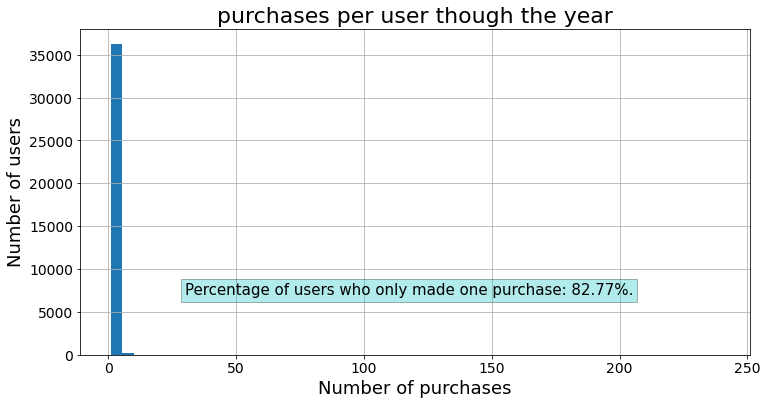

In [42]:
#a quick histogram to show how many times users make purchases:
total_purchases = orders['uid'].value_counts()
total_purchases.hist(bins = 52, figsize = (12,6))
plt.title('purchases per user though the year', size = 22)
plt.ylabel('Number of users', size = 18)
plt.xlabel('Number of purchases', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.text(30,7000, 'Percentage of users who only made one purchase: {:.2%}.'
         .format((total_purchases[total_purchases == 1].count()) / total_purchases.count())
         , fontsize = 15, bbox = dict(facecolor = 'c', alpha = 0.3))
plt.show()

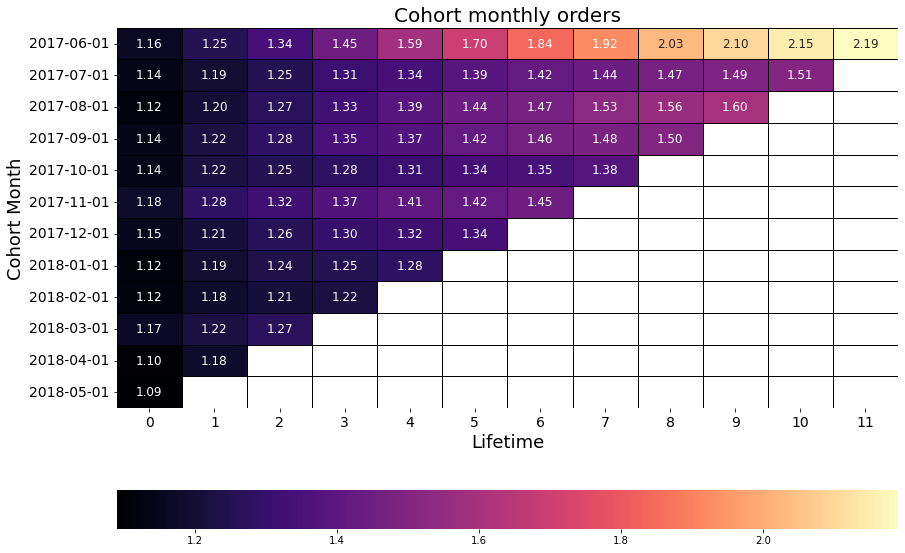

In [43]:
#creating the purchases per user cohort table
cohort_table = (cohorts.pivot_table(index = 'cohort_m', columns = 'month_lt', values = 'user_orders', aggfunc = 'sum')
                .cumsum(axis = 1)).round(2).iloc[:12 , :]
cohort_table.index = cohort_table.index.astype(str)

#the heatmap:
plt.figure(figsize = (14,10))
sns.heatmap(cohort_table, annot = True, fmt = '.2f', linewidths= 1, linecolor='black', cmap = ('magma'),annot_kws={'size':12},
            vmin = (cohort_table.min().min()), vmax = (cohort_table.max().max()), cbar_kws={"orientation": "horizontal"})
plt.title('Cohort monthly orders', size = 20)
plt.xlabel('Lifetime', size = 18)
plt.ylabel('Cohort Month', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

##### Users often make only one purchase.
- 87% of the users make only 1 purchase.
- With that being said, a small amount of users make repeat purchases of up to 250 times!
- The cohort of June is the most curious one who has the biggest jumps of average purchases that keeps scaling high every month.
- cohorts of June to September reached the highest average of purchases. with June being highest by far.

#### What is the average purchase size?

The average purchase renvenue for the timespan given is: 5.00.


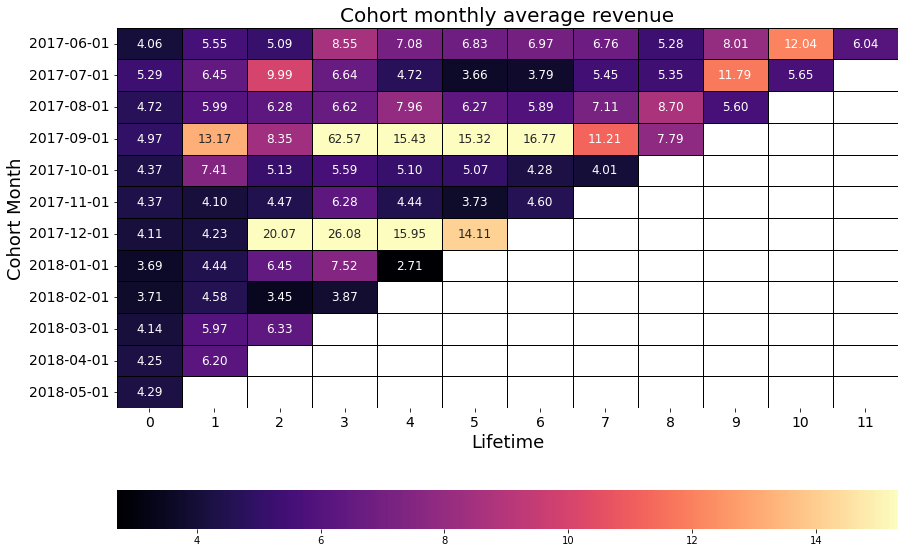

In [44]:
#finding average revenue for each month of each cohort, then lifetime month:
avg_revenue_m = orders.groupby(['cohort_m','purchase_m'])['revenue'].mean().reset_index()
avg_revenue_m['month_lt'] = (
    (avg_revenue_m['purchase_m'] - avg_revenue_m['cohort_m']) / np.timedelta64(1,'M')).round().astype('int')



#creating the pivot table with average revenue per cohort lifetime:
revenue_m_cohorts = (
    avg_revenue_m.pivot_table(index = 'cohort_m' , columns = 'month_lt', values = 'revenue', aggfunc = 'mean').iloc[:12,:])
revenue_m_cohorts.index = revenue_m_cohorts.index.astype(str)

#drawing the heatmap:
plt.figure(figsize = (14,10))
sns.heatmap(revenue_m_cohorts, annot = True, fmt = '.2f', linewidths= 1, linecolor='black', cmap = ('magma'),
            vmin = (revenue_m_cohorts.min().min()), vmax = (revenue_m_cohorts.max().nlargest(5).iloc[-1]),
            annot_kws={'size':12}, cbar_kws={"orientation": "horizontal"})
plt.title('Cohort monthly average revenue', size = 20)
plt.xlabel('Lifetime', size = 18)
plt.ylabel('Cohort Month', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

#so what IS the average??
print('The average purchase renvenue for the timespan given is: {:.2f}.'.format(orders['revenue'].mean()))

##### The average purchase revenue it total is 5.
- The September and December cohorts have some impressive averages. especially at their third lifetime age. the Septmber cohort reached Revenue of 62.5!! that is 12 times the total average!
- This chart does not exactly match the pattern we saw until now, the purchases were great also in the months that user session count was low. perhaps some users buy in bulk? maybe users or a large company buys tickets a few months in advance?.

#### How much money do users bring?

<ipython-input-45-1f23fe8d9fe7>:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('Average revenue growth for all cohorts is: {:.3f}'.format(float(cohort_ltv_growth.mean())))


Average revenue growth for all cohorts is: 0.274


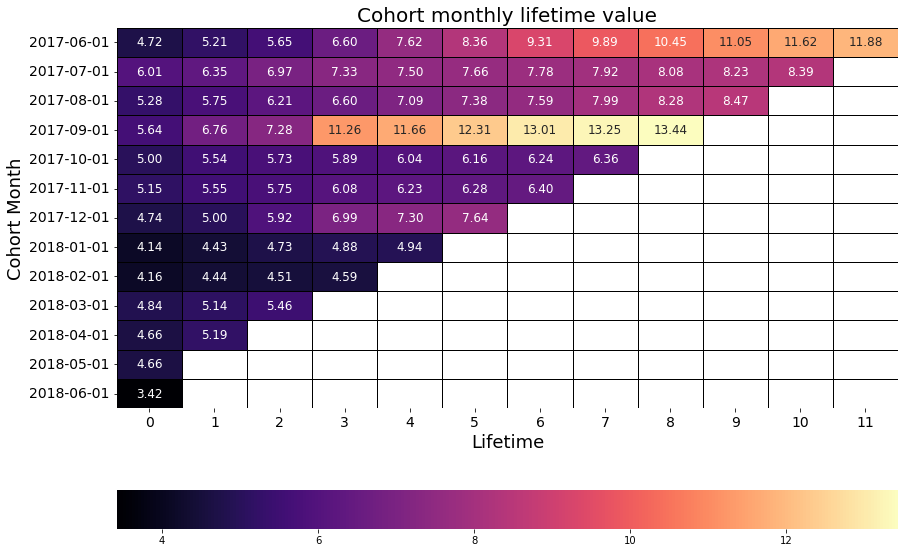

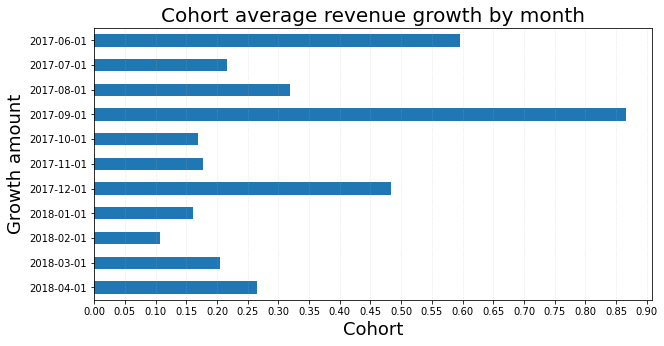

In [45]:
#finding sum of users in each month cohort, creating an ltv table with cohorts and their purchase month and merging the two:
cohort_size = orders.groupby('cohort_m').agg({'uid': 'nunique'}).reset_index().rename(columns = {'uid' : 'cohort_size'})
cohorts_ltv = orders.groupby(['cohort_m','purchase_m'])['revenue'].sum().reset_index()
cohorts_ltv = cohorts_ltv.merge(cohort_size, on='cohort_m')

#adding the month lifetime age, and finding ltv per cohort by deviding revenue by the cohort size:
cohorts_ltv['month_lt'] = ((cohorts_ltv['purchase_m'] - cohorts_ltv['cohort_m']) / np.timedelta64(1,'M')).round().astype('int')
cohorts_ltv['ltv'] = cohorts_ltv['revenue'] / cohorts_ltv['cohort_size']




#creating the usual pivot for our heatmap:
ltv_map = cohorts_ltv.pivot_table(index = 'cohort_m', columns='month_lt', values='ltv', aggfunc='sum').cumsum(axis=1)
ltv_map.index = ltv_map.index.astype(str)

#drawing the heatmap:
plt.figure(figsize = (14,10))
sns.heatmap(ltv_map, annot = True, fmt = '.2f', linewidths= 1, linecolor='black', cmap = ('magma'), annot_kws={'size':12},
            vmin = (ltv_map.min().min()), vmax = (ltv_map.max().max()), cbar_kws={"orientation": "horizontal"})
plt.title('Cohort monthly lifetime value', size = 20)
plt.xlabel('Lifetime', size = 18)
plt.ylabel('Cohort Month', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)

#adding a small graph to show monthly average growth:
cohort_ltv_growth = ((ltv_map.max(axis = 1) - ltv_map.min(axis = 1)) / ltv_map.count(axis = 1)).reset_index().sort_index(ascending = False)
cohort_ltv_growth.iloc[2:,:].plot(figsize = (10, 5), kind = 'barh', x = 'cohort_m', legend = False)
plt.locator_params(axis="x", nbins = 20)
plt.title('Cohort average revenue growth by month', size = 20)
plt.xlabel('Cohort', size = 18)
plt.ylabel('Growth amount', size = 18)
plt.grid(axis = 'x', alpha = 0.4, ls = ':')

print('Average revenue growth for all cohorts is: {:.3f}'.format(float(cohort_ltv_growth.mean())))

##### Users bring more money with time.
- On monthly average, users revenue grow by 0.274, as we can see in the June cohort, by the end of the year the revenue is 3 times bigger. it is a good idea to have users to come back.
- we can see there is no consistency in growth between different cohorts, but this could be due to not all cohorts reaching a full year cycle.

#### Overall Sales conclusions:
- A time span of 12 months is a good start, but maybe we need more than that to complete a year cycle to all the cohorts.
- Almost 50% of the users who purchased, made their purchase as soon as they visit the service for the first time.
- But only 16% of users ever made a purchase, perhaps we could create some incentive on making a first purchase?.
- Most users (87%) only make one or a couple of purchases, but some users make hundreds. maybe it's worth understanding what kind of users they are?
- the June and September cohorts were very successful in terms of purchasing. for example the September cohort reached top of 62.5 average revenue at December. perhaps it's because of seasonal events? perhaps these cohorts have some exceptional users?
- in a year, returning purchasing users can spend 3 times their initial purchase. increasing such customers should very profitable.

### Sales
#### How much money was spent? Overall/per source/over time

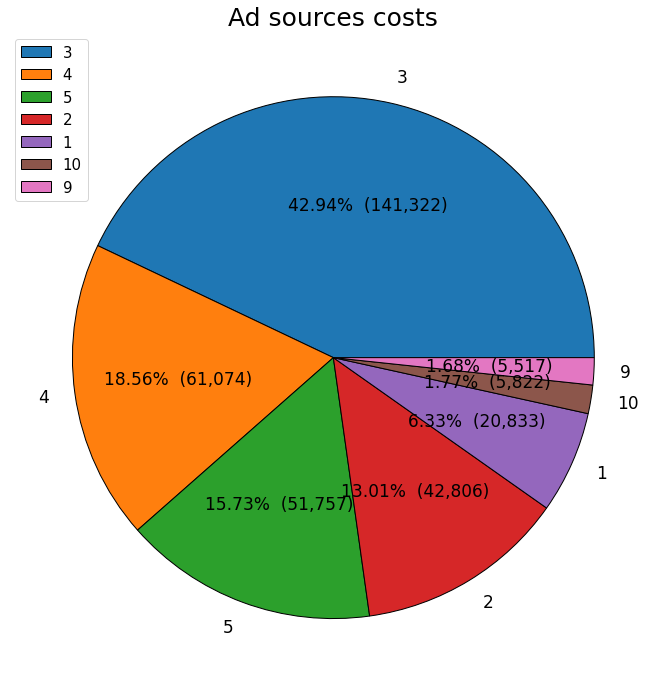

In [46]:
#adding month of ad cost:
costs['month'] = costs['dt'].astype('datetime64[M]')
#finding cost per source
source_cost = costs.groupby('source_id')['costs'].sum().sort_values(ascending = False).reset_index()
source_cost#.reset_index()

#drawing a pie:
plt.figure(figsize = (12,12))
plt.pie(x = source_cost['costs'], labels = source_cost['source_id'], wedgeprops={"edgecolor" : "k", 'linewidth' : 1},
        textprops={'color' : 'k', 'fontsize': 17},
        autopct = lambda x : '{:.2f}%  ({:,.0f})'.format(x,x * sum(source_cost['costs'])/100))
plt.title('Ad sources costs', size = 25)
plt.legend(fontsize = 15)
plt.show()

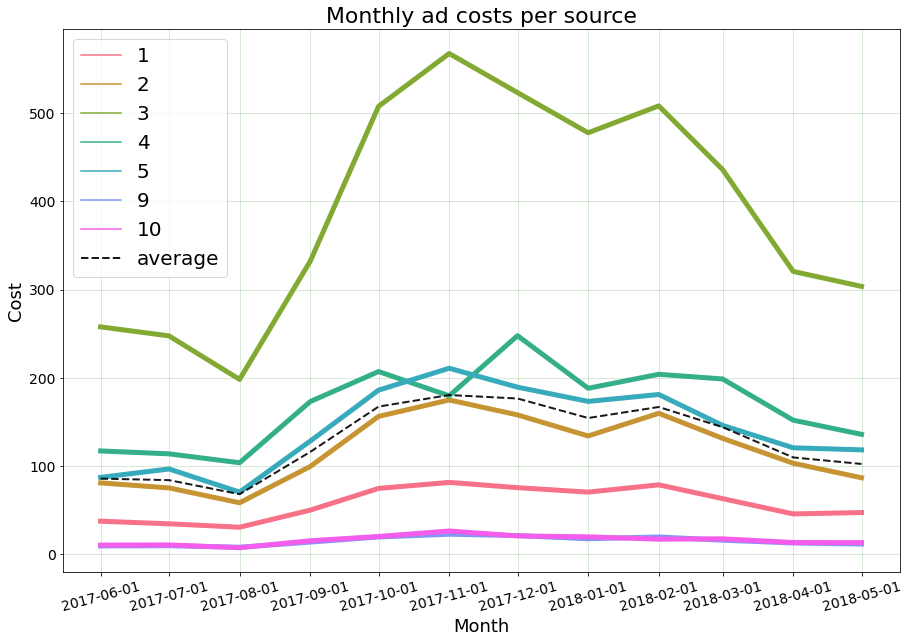

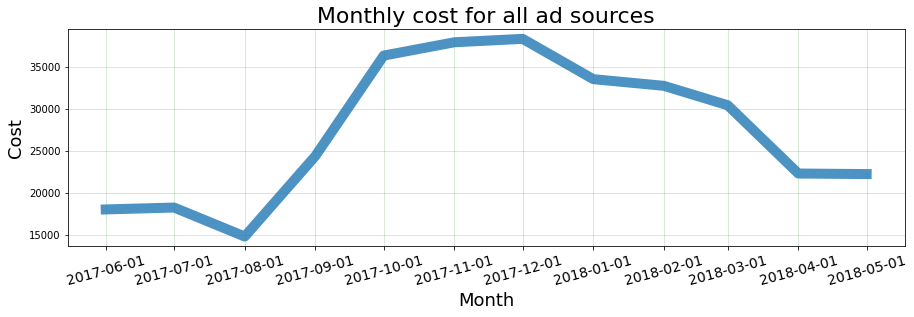

Overall cost for all ad sources: 329,131.


In [47]:
#then a monthly line plot for costs of each source:
plt.figure(figsize = (15, 10))
sns.lineplot(data = costs, y = 'costs', x = 'month', ci=None, hue = 'source_id', palette = (sns.color_palette("husl", 7)),
                                                                                                            linewidth = 5)
sns.lineplot(data=costs, x='month', y=costs['costs'], ci=None, linewidth=2, alpha = 0.9, ls = '--', color = 'k',
                                                                                                         label = 'average')
plt.title('Monthly ad costs per source', size = 22)
plt.xlabel('Month', size=18)
plt.ylabel('Cost', size=18)
plt.legend(fontsize = 20, loc = 'upper left')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks = costs['month'].unique())
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 15)
plt.grid(axis = 'both', color = 'g', alpha = 0.2)
plt.show()

#and a monthly line plot for the total costs:
plt.figure(figsize = (15, 4))
sns.lineplot(data=costs, x='month', y=costs['costs'], estimator='sum', ci=None, linewidth=10, alpha = 0.8)
plt.title('Monthly cost for all ad sources', size = 22)
plt.xlabel('Month', size=18)
plt.ylabel('Cost', size=18)
plt.grid(axis = 'both', color = 'g', alpha = 0.2)
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 15)
plt.xticks(ticks = costs['month'].unique())
plt.show()


#adding overall cost from all sources
print('Overall cost for all ad sources: {:,}.'.format(int(costs['costs'].sum())))

##### Overall, ad costs reach 329,131.
- Source 3 takes 42% of all costs (141,322) this is a much higher than any other source it better be good!.
- all source costs, are parallel, it seems the company funds for the different adverstising sources keeps its ratio as the total funding grow or shrink.
- The highest advertising costs were from October to March.
- The lowest marketing costs were from June(17) to September, and then from April(18) onwards.
- 9, and 10 sources get very little funding of about 1.7% each (5,517 / 5822).
- if we count sources from 1 to 10,  where are 6, 7, and 8? could they be free sources? could they be missing? or not in use anymore?
- the funding on sources seem logical with the rest of our analysis, October to February are the highest funded months, and also the months that have most visits, hey maybe advertising works!

#### How much did customer acquisition from each of the sources cost?

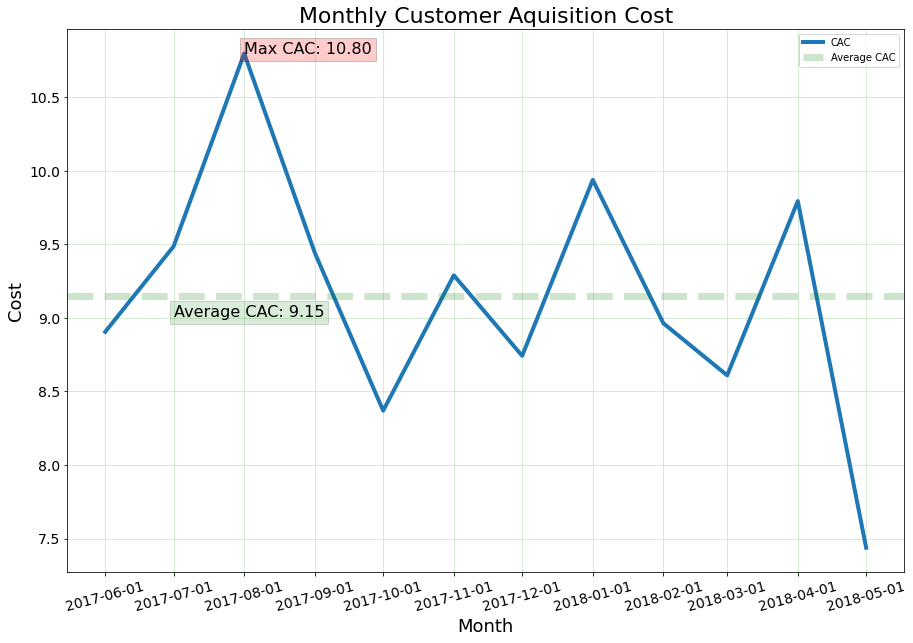

In [48]:
#taking monthly costs from advetisements, monthly customers from orders, merging them, then calculating CAC:
costs_month = costs.groupby('month')['costs'].sum().reset_index()
user_orders_m = orders.groupby('cohort_m')['uid'].nunique().reset_index().rename(columns = {'cohort_m' : 'month', 'uid' : 'buyers'})
monthly_cac = costs_month.merge(user_orders_m, how='left', on='month')
monthly_cac['cac'] = monthly_cac['costs'] / monthly_cac['buyers']



#lets see the monthly CAC:
plt.figure(figsize = (15, 10))
sns.lineplot(data = monthly_cac, y = 'cac', x = 'month', linewidth = 4, label = 'CAC')
plt.title('Monthly Customer Aquisition Cost', size = 22)
plt.xlabel('Month', size=18)
plt.ylabel('Cost', size=18)
plt.axhline(y = (monthly_cac['cac'].mean()), color = 'g', linewidth = 7, alpha = 0.2, ls = '--', label = 'Average CAC')
plt.text(monthly_cac.iloc[2,0], monthly_cac['cac'].max(), 'Max CAC: {:.2f}'.format(monthly_cac['cac'].max()),
         bbox = dict(facecolor = 'r', alpha = 0.2), size = 16)
plt.text(monthly_cac.iloc[1,0], monthly_cac['cac'].mean()-0.14, 'Average CAC: {:.2f}'.format(monthly_cac['cac'].mean()),
         bbox = dict(facecolor = 'g', alpha = 0.15), size = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks = monthly_cac['month'].unique())
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 15)
plt.grid(axis = 'both', color = 'g', alpha = 0.2)
plt.legend()
plt.show()

##### Monthly CAC is at peak in August with 10.8
- August is the month with lowest user activity, and low revenue. it's CAC is at peak maybe because there was also very little advertising costs
- In December, there was a lot of user activity, and also a good revenue, but CAC is low at this month.
- CAC seems to be similar (with small ups and downs) through the rest of the year.

##### CAC per source

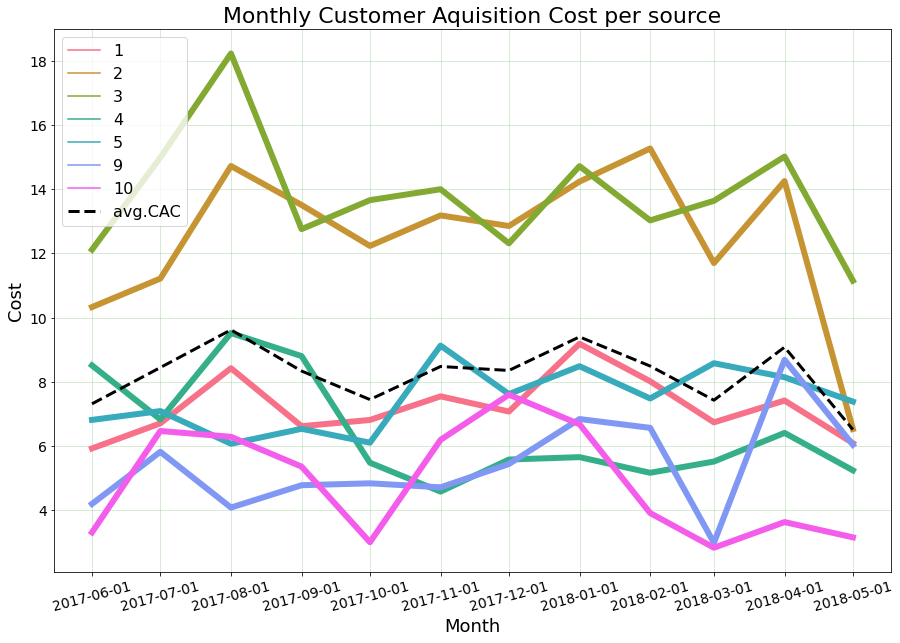

In [49]:
#finding what source users came through on their first visit, and merging to orders:
first_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index().rename(columns = {'source_id' : 'first_source'})
orders = orders.merge(first_source, on = 'uid', how = 'left')

#finding the sum of costs for each source by month, then from the orders how many users came from each source cohort
source_cost_month = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index().rename(columns = {'month' : 'cost_month', 'source_id' : 'first_source'})
source_cohort_buyers = orders.groupby(['cohort_m', 'first_source'])['uid'].nunique().reset_index().rename(columns = {'cohort_m' : 'cost_month', 'uid' : 'buyers'})

#merging the monthly sources cost with the sum of buyers per source cohort:
source_m_cac = source_cost_month.merge(source_cohort_buyers,how='left',on = ['cost_month', 'first_source'])
source_m_cac['cac'] = source_m_cac['costs'] / source_m_cac['buyers']



#calculating monthly mean for all sources combined:
source_m_cac_mean = source_m_cac.groupby('cost_month')['cac'].mean().reset_index()

#drawing monthly CAC
plt.figure(figsize = (15, 10))
sns.lineplot(data = source_m_cac, y = 'cac', x = 'cost_month', hue = 'first_source', palette = (sns.color_palette("husl", 7)), linewidth = 6)
sns.lineplot(data = source_m_cac_mean, y = 'cac', x = 'cost_month', linewidth = 3, label = 'avg.CAC', ls = '--', color = 'k')
    #previous total monthly cac without breaking into sources:     
    #sns.lineplot(data = monthly_cac, y = 'cac', x = 'month', linewidth = 3, label = 'CAC', ls = ':', color = 'k', alpha = 0.6)
plt.title('Monthly Customer Aquisition Cost per source', size = 22)
plt.xlabel('Month', size=18)
plt.ylabel('Cost', size=18)
plt.legend(fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks = source_m_cac['cost_month'].unique())
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 15)
plt.grid(axis = 'both', color = 'g', alpha = 0.2)
plt.show()

##### Clearly source 3 has the highest CAC with source 2 right behind it.
- All ad sources seem to have a similar movement of buyers with time. parallel to our previous analysis.
- In CAC terms: source 3 and 2 have the highest customer aquisition costs; reaching 18, and 14.5 in August.<br>
    Although buyers who came first through source 3 are the most buyers through the year(10,473), ad source 4 for example has almost the same amount of buyers(10,295) for half the CAC (8.5 in Aug).
- Source 2 is also high on CAC(14.5 in Aug), and has much less buyers throughout the year(3506).
- Different sources CAC peak at different months, August is one of the highest peaks for most sources, then January and November.

##### It is interesting to see how many buyers each source brings

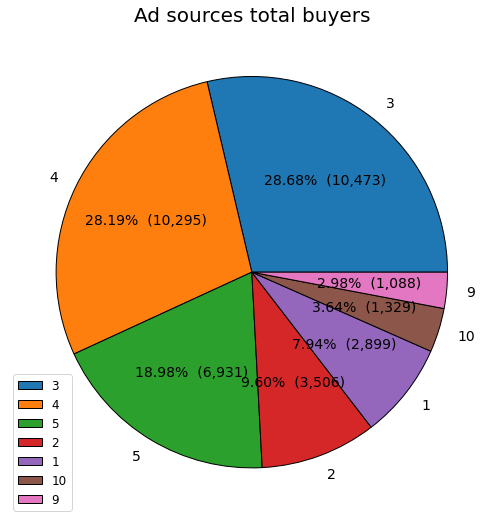

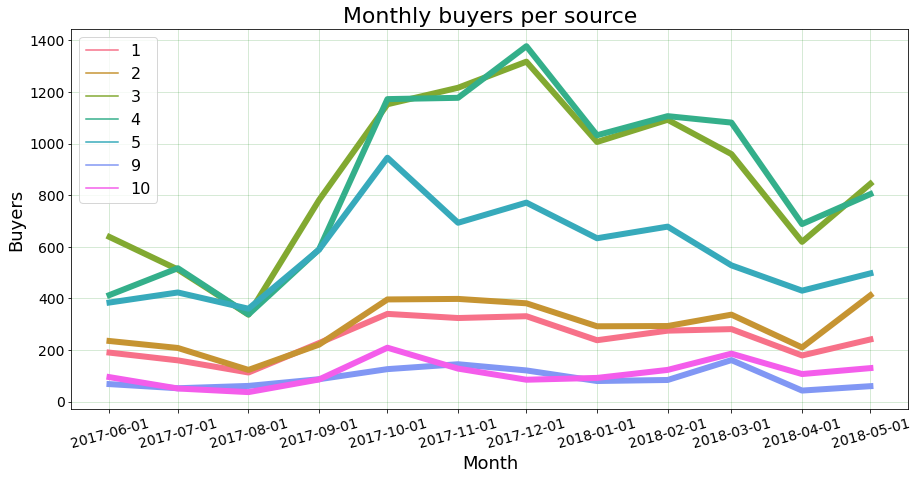

In [50]:
#checking amount of monthly buyers per source:
monthly_source_buyers = source_m_cac.groupby(['first_source', 'cost_month'])['buyers'].sum().reset_index()

#total buyers per source:
m_source_buyers = monthly_source_buyers.groupby('first_source')['buyers'].sum().sort_values(ascending = False).reset_index()
m_source_buyers
# #baking a buyers per source pie:
plt.figure(figsize = (9,9))
plt.pie(m_source_buyers['buyers'], labels = m_source_buyers['first_source'], 
        autopct = lambda x : '{:.2f}%  ({:,.0f})'.format(x,x * sum(m_source_buyers['buyers'])/100),
        wedgeprops={"edgecolor" : "k", 'linewidth' : 1}, textprops={'color' : 'k', 'fontsize': 14})
plt.title('Ad sources total buyers', size = 20)
plt.legend(fontsize = 12)
plt.show()


#drawing monthly buyers per source:
plt.figure(figsize = (15, 7))
sns.lineplot(data = monthly_source_buyers, y = 'buyers', x = 'cost_month', hue = 'first_source',
                                                                 palette = (sns.color_palette("husl", 7)), linewidth = 6)
plt.title('Monthly buyers per source', size = 22)
plt.xlabel('Month', size=18)
plt.ylabel('Buyers', size=18)
plt.legend(fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks = source_m_cac['cost_month'].unique())
plt.tick_params(axis='x', which='major', labelsize=14, labelrotation= 15)
plt.grid(axis = 'both', color = 'g', alpha = 0.2)
plt.show()

#### How worthwhile where the investments? (ROI)

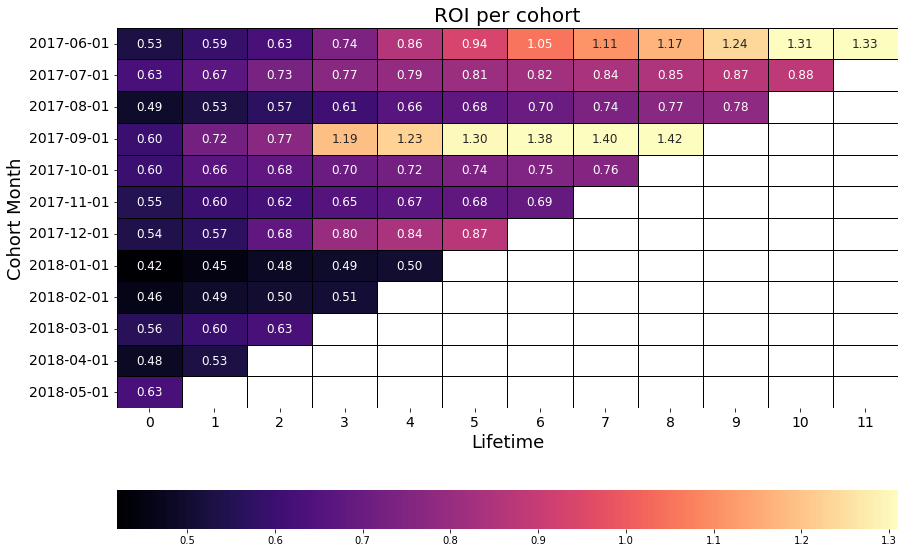

In [51]:
#finding monthly cac and ltv per month cohort and merging them together, then calculating monthly roi
monthly_cac_roi = monthly_cac[['month', 'cac']].rename(columns = {'month' : 'cohort_m'})
roi = cohorts_ltv.merge(monthly_cac_roi, on = 'cohort_m', how = 'left')
roi = roi.rename(columns = {'cohort_m' : 'first_order_month'})
roi['roi'] = roi['ltv'] / roi['cac']



#creating table of ROI per cohort, and drawing a heatmap:
roi_cohorts_table = roi.pivot_table(index='first_order_month', columns='month_lt', values='roi', aggfunc='mean').cumsum(axis=1).round(2) 
roi_cohorts_table.index=roi_cohorts_table.index.astype(str)

plt.figure(figsize = (14,10))
sns.heatmap(roi_cohorts_table, annot = True, fmt = '.2f', linewidths= 1, linecolor='black', cmap = ('magma'), annot_kws={'size':12},
            vmin = (roi_cohorts_table.min().min()), vmax = (roi_cohorts_table.max().nlargest(5).iloc[-1]), cbar_kws={"orientation": "horizontal"})
plt.title('ROI per cohort', size = 20)
plt.xlabel('Lifetime', size = 18)
plt.ylabel('Cohort Month', size = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

##### The June and September cohorts are the most successful in terms of ROI.
- The September cohort had a big jump in it's 3rd lifetime (December).
- It seems ROI climbs up VERY slow each month, for most of the cohorts, it's very low even at the last lifetime.
- January and February are especially low, perhaps they need a few more months to heat up?

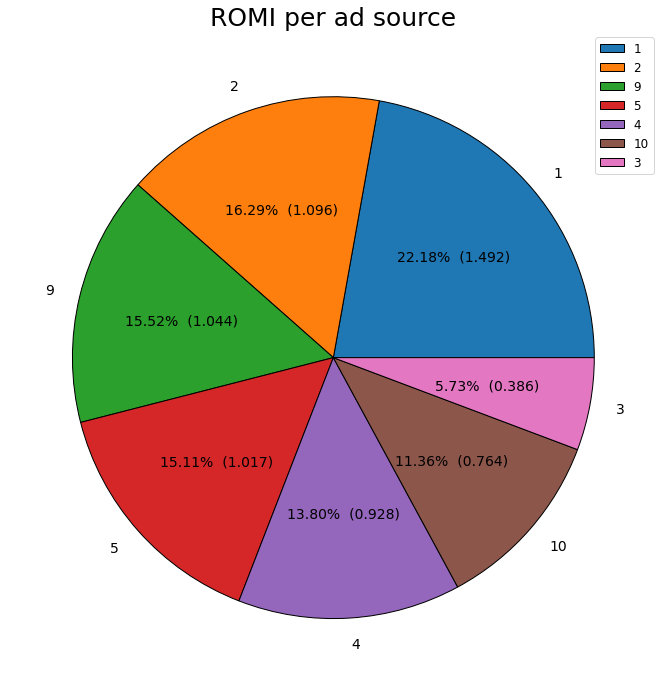

In [52]:
#creating LTV by deviding revenue by buyers from the orders table:
source_ltv = orders.groupby('first_source')[['uid','revenue']].agg({'uid':'nunique','revenue':'sum'}).reset_index().rename(
                                                                    columns = {'first_source' : 'source', 'uid' : 'buyers'})
source_ltv['ltv'] = source_ltv['revenue'] / source_ltv['buyers']


#finding total costs per ad source, and then merging it with the LTV values to calculate ROMI per source
source_costs = costs.groupby('source_id')['costs'].sum().reset_index().rename(columns = {'source_id' : 'source'})
source_roi = source_costs.merge(source_ltv, on = 'source')
source_roi['cac'] = source_roi['costs'] / source_roi['buyers']
source_roi['romi'] = source_roi['ltv'] / source_roi['cac']


#baking a ROMI per source pie:                        and thinking of lemon pie
srcromi = source_roi[['source', 'romi']].sort_values('romi', ascending = False).reset_index(drop = True)

plt.figure(figsize = (12,12))
plt.pie(srcromi['romi'], labels = srcromi['source'],
        autopct = lambda x : '{:.2f}%  ({:,.3f})'.format(x,x * sum(srcromi['romi'])/100),
        wedgeprops={"edgecolor" : "k", 'linewidth' : 1}, textprops={'color' : 'k', 'fontsize': 14})
plt.title('ROMI per ad source', size = 25)
plt.legend(fontsize = 12)
plt.show()

##### Source 1 has the best ROMI value of 1.49:
- Other than source 1, the better ad sources are also 2, 9, and 5.
- Source 3 has the lowest ROMI of 0.38.

## Overall conclusions and advice:
#### After reading and preprocessing the 3 files(visits, orders, and costs), there were not find too many anomallies was a relief, some points to remember:
- The revenue column in the orders table, had 0 values. maybe free goods, compensation, prepaid, or data error. They were regarded as valid values.
- There are Very high values in the orders table for revenue. maybe a group purchase,  a company, maybe an error, maybe even a person/bot trying to buy and resell?, either way it should be examined.
- Ad source 5 from the costs table had an extra day of cost. It is just a little bit suspicious. The same users entered the service a handful of times and did not purchase anything.
- In the vists table, for rows: 4181, and 177972, the start_ts timestamp is later than the end_ts timestamp.
- In march 31, there was only 1 user active, is this a bug? or just a very bad day?
- The start_ts is rounded by minutes, and the end ts is mostly too, but there are some end_ts values that are rounded to 19 seconds (HH:MM:19). to see it, use:  visits['end_ts'].dt.second.unique()  .

### Miscelleneous points:
- The strongest months for are October to March. With more visits and orders than the rest of the year. 
- There was a huge spike in november 24 with 3319 sessions that day, it could be a good marketing move, something that happened that day or due to happen, or maybe just an error. 
- The June and September user cohorts were very successful in all terms. For example the September cohort reached top of 62.5 average revenue at December. perhaps it's because of seasonal events? perhaps these cohorts have some exceptional users?<br>
    The June cohort has the biggest jumps of purchase average, that keeps scaling high every month.

### User behaviour:
- Users times:
    - Most sessions last a minute.
    - Some sessions last from to 10 to 13 minutes (this raises the average session time to 10 minutes), maybe these are the sessions where orders were made?.
        It's a good idea to consider having a timer to end the session after inactivity.
- 73% of users are visiting from a desktop pc. it could be a more comfortable interface.
- Daily average of users who access the service is 908
- Most users use the service only once in a day with 1.08 average daily sessions per user.
- Only 16% of users have actually purchased something.
- 50% of buyers have made their first order on the same day they registered. and most of the other 50% took no longer than 2 months. few users took a year to make their first order.
- 87% of the users make only 1 purchase. and a few made as many as 250 purchases!.
- Retention rate is not great, but it is still positive. it means a portion of the initial users do come back even after a year.
- Within a year, returning purchases can make 3 times the initial purchase.
#### Recommendations:
1. **As only few users make a first purchase, and out of them only a few make repeat purchases, it is a good idea to encourage users to make a first purchase.**
2. **Also Repeat purchases should be encouraged.**<br>
     **maybe a benefit membership club? discount or special seats reserved?. make it something exciting!**
3. **With 73% of sessions coming from desktop. Maybe it's good to focus on desktop users. But also the mobile interface or usage must be checked or improved, maybe it's inconvinient.**
4. **Perhaps it's good to focus on desktop. And just to be sure, check how good is the touch interface.**
    
### Sources of advertising:
- Overall, ad costs reach 329,131.
- In terms of ROMI, all sources are positive.
- Source 3:
    - Has total cost of 141,322. This is 43% of the sources total cost.
    - Has the highest CAC with average of 13.8, and reached 18 in August with source 2 right behind it.
    - Has 10,473 buyers in total, ad source 4 for example has almost the same amount of buyers(10,295) for half the CAC (6.4 in total, and 8.5 in Aug).
    - Has a VERY low ROMI of 0.38
- Source 1: Has ROMI of 1.4, a CAC of 7.2 and total cost of 20,000.
#### Recommendations:
1. **It seems right to invest more on source 1.**
2. **It also seems right to cut on source 3 as it is too expensive and not bringing as much as other sources.**
